In [33]:
import os
import requests
import shutil
import time
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
def download_file(downloadURL, downloadDir):
    baseName = downloadURL.split('/')[-1]
    downloadFile = os.path.join(downloadDir, baseName)
    
    if not os.path.exists(downloadDir):
        os.mkdir(downloadDir)
    
    with requests.get(downloadURL, stream=True) as r:
        with open(downloadFile, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    return downloadFile

In [12]:
downloadURL='http://cs231n.stanford.edu/tiny-imagenet-200.zip'
downloadDir='../datasets'

downloadFile = download_file(downloadURL, downloadDir)

In [13]:
extractDir='../datasets'

shutil.unpack_archive(downloadFile, extractDir)

In [31]:
def preprocess_validation(dataDir, labelsFile):
    
    imageSubDir='images'
    imageDir=os.path.join(dataDir, imageSubDir)

    # Read in the 50000 synsets associated with the validation data set.
    with open(labelsFile) as f:
        labels = f.readlines()
        labels = [x.split('\t')[:2] for x in labels]    
        
        imageList = []
        for imageFile, wordnetId in labels:
            imageList.append({'inputFile': os.path.join(dataDir, imageSubDir, imageFile),
             'outputFile': os.path.join(dataDir, wordnetId, imageFile),
             'outputDir': os.path.join(dataDir, wordnetId)})
        
    for imageDict in imageList:
        if not os.path.exists(imageDict['outputDir']):
            os.mkdir(imageDict['outputDir'])
            
        if not os.path.exists(imageDict['outputFile']):
            os.rename(imageDict['inputFile'], imageDict['outputFile'])
            
    if os.path.exists(imageDir):
        os.rmdir(imageDir)

In [41]:
validationDir = '../datasets/tiny-imagenet-200/val'
labelsFile = '../datasets/tiny-imagenet-200/val/val_annotations.txt'

preprocess_validation(validationDir, labelsFile)

## Train model

In [42]:
dataTrainDir = '../datasets/tiny-imagenet-200/train'
dataValDir = '../datasets/tiny-imagenet-200/val'

resultsDir = 'results'
modelsDir = 'models/imagenet_xception'
logsDir = 'logs/imagenet_xception'

In [56]:
NUM_GPUS = 1
BS_PER_GPU = 64
NUM_EPOCHS = 50

HEIGHT = 64
WIDTH = 64
NUM_CHANNELS = 3
NUM_CLASSES = 200

IMAGE_SIZE = (HEIGHT, WIDTH)

In [43]:
if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
    os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
    os.makedirs(logsDir)

In [44]:
train_class = next(os.walk(dataTrainDir))[1]
train_class.sort()
print("Number of folders in TrainDir: {}".format(len(train_class)))

val_class = train_class

Number of folders in TrainDir: 200


In [52]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataTrainDir,
    labels='inferred',
    class_names=train_class,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BS_PER_GPU,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataValDir,
    labels='inferred',
    class_names=val_class,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BS_PER_GPU,
)

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


## data augmentation

In [53]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [54]:
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [55]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

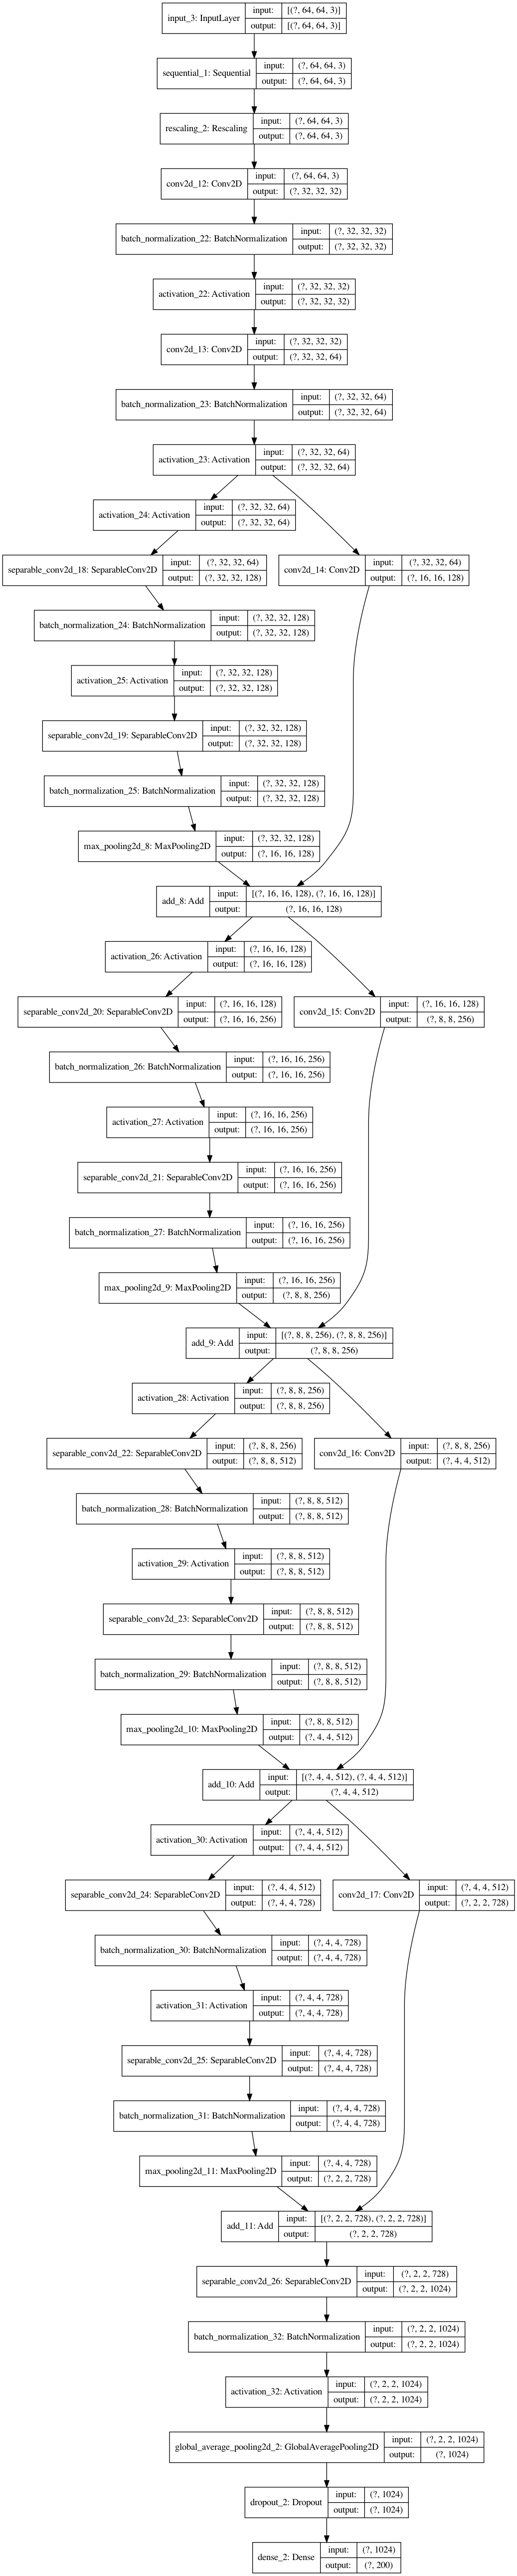

In [61]:
modelDiagramFile = os.path.join(resultsDir, 'model_imagenet_Xception.png')

model = make_model(input_shape=IMAGE_SIZE + (NUM_CHANNELS,), num_classes=NUM_CLASSES)
keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)

In [60]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5")),
    keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1),
]

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

startTime = time.time()

model.fit(train_ds,
          epochs=NUM_EPOCHS,
          callbacks=callbacks,
          validation_data=val_ds,
          validation_freq=1)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Epoch 1/50
   1/1563 [..............................] - ETA: 0s - loss: 5.4700 - sparse_categorical_accuracy: 0.0000e+00WARNING:tensorflow:From /Users/rmunoz/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 226/1563 [===>..........................] - ETA: 26:06 - loss: 5.2103 - sparse_categorical_accuracy: 0.0243

KeyboardInterrupt: 